Greadsearching su un gradient boosting

In [3]:
"""import os
import time
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
from typing import List, Dict 

# --- Importazioni dal tuo file di utility ---
# Assicurati che 'start_utils.py' sia nella stessa cartella
from start_utils import create_features, read_train_data, read_test_data

# --- Importazioni per il Modello Avanzato ---
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
import warnings

def main():
    # Ignora i warning per un output più pulito
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    # === 1. CARICAMENTO DATI ===
    print("--- 1. Caricamento Dati ---")
    COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
    # Modifica il percorso se 'input' non è nella stessa cartella di 'start.py'
    DATA_PATH = 'input' 
    
    train_file_path = os.path.join(DATA_PATH, COMPETITION_NAME, 'train.jsonl')
    test_file_path = os.path.join(DATA_PATH, COMPETITION_NAME, 'test.jsonl')

    try:
        train_data = read_train_data(train_file_path)
        test_data = read_test_data(test_file_path)
        print(f"Dati di training caricati: {len(train_data)} battaglie.")
        print(f"Dati di test caricati: {len(test_data)} battaglie.")
    except FileNotFoundError:
        print(f"ERRORE: Dati non trovati. Assicurati che la cartella '{DATA_PATH}/{COMPETITION_NAME}' esista.")
        return

    # === 2. CREAZIONE FEATURE ===
    print("\n--- 2. Creazione Feature (Feature Engineering) ---")
    
    print("Processing training data...")
    train_df = create_features(train_data)
    
    print("\nProcessing test data...")
    test_df = create_features(test_data, is_test=True)

    # === 3. SELEZIONE FEATURE (Il set vincente!) ===
    print("\n--- 3. Selezione Feature (Pre-Training) ---")

    # Questa è la lista di feature che ha dato i risultati migliori (96.31%)
    # Derivata dalla nostra analisi di importanza precedente.
    TOP_FEATURES = [
        'status_change_diff',
        'diff_final_schieramento',
        'diff_final_hp',
        'p1_bad_status_advantage',
        'p1_pct_final_hp',
        'p2_n_pokemon_use',
        'p2_hp_std',
        'diff_hp',
        'p1_hp_std',
        'hp_delta_std'
        # Aggiungi qui altre feature che erano nel tuo 'TOP_FEATURES' se diverse
    ]
    
    # Aggiungiamo le nuove feature di danno che abbiamo integrato
    TOP_FEATURES.extend(['diff_move_damage_mean', 'diff_move_damage_max'])
    
    # Rimuoviamo duplicati se ce ne sono
    TOP_FEATURES = sorted(list(set(TOP_FEATURES))) 
    
    print(f"Utilizzo di {len(TOP_FEATURES)} feature selezionate.")

    TARGET = 'player_won'
    
    # Creiamo i set di dati X/y usando SOLO le feature migliori
    X = train_df[TOP_FEATURES]
    y = train_df[TARGET]
    
    # Prepariamo il set di test
    X_test = test_df[TOP_FEATURES]

    # === 4. OTTIMIZZAZIONE MODELLO (Grid Search) ===
    print("\n--- 4. Ottimizzazione Modello (Grid Search) ---")
    start_time = time.time()

    # Definiamo il modello base
    gb_model = GradientBoostingClassifier(random_state=42)

    # Definiamo la griglia che ha prodotto i risultati migliori
    param_grid = {
        'n_estimators': [300, 500],
        'learning_rate': [0.05, 0.1],
        'max_depth': [5, 7]
    }
    # (Ho ristretto la griglia ai valori vicini a quelli vincenti per velocizzare)

    # Definiamo la Cross-Validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Inizializza GridSearch
    grid_search = GridSearchCV(
        estimator=gb_model, 
        param_grid=param_grid, 
        scoring='accuracy', 
        cv=kf, 
        verbose=2, # Mostra i progressi
        n_jobs=-1  # Usa tutti i processori
    )
    
    grid_search.fit(X, y)

    print("\n--- 📊 Risultati Ottimizzazione ---")
    print(f"Migliore Accuratezza in Cross-Validation: {grid_search.best_score_:.4f}")
    print(f"Migliori Iperparametri Trovati: {grid_search.best_params_}")
    
    end_time = time.time()
    print(f"Tempo di ottimizzazione: {(end_time - start_time) / 60:.2f} minuti")

    # === 5. CREAZIONE SUBMISSION ===
    print("\n--- 5. Creazione File di Submission ---")
    
    best_model = grid_search.best_estimator_
    
    predictions = best_model.predict(X_test)

    submission_df = pd.DataFrame({
        'battle_id': test_df['battle_id'],
        TARGET: predictions
    })

    submission_df.to_csv('submission1.csv', index=False)
    print("File 'submission1.csv' creato con successo!")

# --- Esecuzione dello script ---
if __name__ == "__main__":
    main()"""

'import os\nimport time\nimport pandas as pd\nimport numpy as np\nimport json\nfrom tqdm import tqdm\nfrom typing import List, Dict \n\n# --- Importazioni dal tuo file di utility ---\n# Assicurati che \'start_utils.py\' sia nella stessa cartella\nfrom start_utils import create_features, read_train_data, read_test_data\n\n# --- Importazioni per il Modello Avanzato ---\nfrom sklearn.ensemble import GradientBoostingClassifier\nfrom sklearn.model_selection import StratifiedKFold, GridSearchCV\nfrom sklearn.metrics import accuracy_score\nimport warnings\n\ndef main():\n    # Ignora i warning per un output più pulito\n    warnings.simplefilter(action=\'ignore\', category=FutureWarning)\n\n    # === 1. CARICAMENTO DATI ===\n    print("--- 1. Caricamento Dati ---")\n    COMPETITION_NAME = \'fds-pokemon-battles-prediction-2025\'\n    # Modifica il percorso se \'input\' non è nella stessa cartella di \'start.py\'\n    DATA_PATH = \'input\' \n\n    train_file_path = os.path.join(DATA_PATH, COMPET

uso modelli random forest e ada boosting e poi li faccio votare tra loro per capire quale è l'aproccio migliore

In [4]:
import os
import time
import pandas as pd
import numpy as np
import json
from tqdm import tqdm

# --- Importazioni dal tuo file di utility ---
from start_utils import build_pokedex, create_features, read_train_data, read_test_data

# --- Importazioni per i Nuovi Modelli ---
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import warnings

def main():
    # Ignora i warning per un output più pulito
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    # === 1. CARICAMENTO DATI ===
    print("--- 1. Caricamento Dati ---")
    COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
    DATA_PATH = 'input' 
    
    train_file_path = os.path.join(DATA_PATH, COMPETITION_NAME, 'train.jsonl')
    test_file_path = os.path.join(DATA_PATH, COMPETITION_NAME, 'test.jsonl')

    try:
        train_data = read_train_data(train_file_path)
        test_data = read_test_data(test_file_path)
        print(f"Dati di training caricati: {len(train_data)} battaglie.")
        print(f"Dati di test caricati: {len(test_data)} battaglie.")
    except FileNotFoundError:
        print(f"ERRORE: Dati non trovati. Assicurati che la cartella '{DATA_PATH}/{COMPETITION_NAME}' esista.")
        return
    
    # --- 2. COSTRUZIONE POKEDEX  ---
    # Combiniamo i dati per trovare tutti i Pokémon
    all_data = train_data + test_data
    # CHIAMIAMO LA FUNZIONE per creare il dizionario
    POKEDEX = build_pokedex(all_data)

    # === 2. CREAZIONE FEATURE ===
    print("\n--- 2. Creazione Feature (Feature Engineering) ---")
    
    print("Processing training data...")
    train_df = create_features(train_data,POKEDEX)
    
    print("\nProcessing test data...")
    test_df = create_features(test_data,POKEDEX, is_test=True)

    # === 3. SELEZIONE FEATURE ===
    print("\n--- 3. Selezione Feature (Pre-Training) ---")

    # Usiamo le feature che sappiamo essere forti
    # (Sentiti libero di usare la tua lista 'TOP_FEATURES' se l'hai salvata)
    features_da_usare = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]
    
    print(f"Utilizzo di {len(features_da_usare)} feature totali.")

    TARGET = 'player_won'
    
    X = train_df[features_da_usare]
    y = train_df[TARGET]
    X_test = test_df[features_da_usare]

    # === 4. DEFINIZIONE MODELLI (RF + AdaBoost) ===
    print("\n--- 4. Definizione Modelli Non Lineari ---")
    start_time = time.time()

    # Modello 1: RandomForestClassifier
    # (Un buon punto di partenza: 300 alberi, profondità massima 7)
    clf_rf = RandomForestClassifier(
        n_estimators=300, 
        max_depth=7, 
        random_state=42, 
        n_jobs=-1
    )

    # Modello 2: AdaBoostClassifier
    # (Un buon punto di partenza: 500 stimatori, learning rate 0.1)
    clf_ada = AdaBoostClassifier(
        n_estimators=500, 
        learning_rate=0.1, 
        random_state=42
    )

    # Modello 3: VotingClassifier
    # Combina i due modelli. 'voting='soft'' fa la media delle probabilità (di solito è meglio).
    print("Combinazione dei modelli in un VotingClassifier...")
    voting_clf = VotingClassifier(
        estimators=[
            ('rf', clf_rf),  # (nome, modello)
            ('ada', clf_ada) # (nome, modello)
        ],
        voting='soft' # 'soft' fa la media delle probabilità, 'hard' fa votare 0 o 1
    )
    
    """
    # === 5. VALIDAZIONE VELOCE (Opzionale) ===
    # Controlliamo rapidamente le prestazioni prima del training finale
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    print("\nValidazione del VotingClassifier (potrebbe richiedere un minuto)...")
    voting_scores = cross_val_score(voting_clf, X, y, cv=kf, scoring='accuracy', n_jobs=-1)
    print(f"Accuratezza media CV del VotingClassifier: {np.mean(voting_scores):.4f}")

    # === 6. TRAINING FINALE E SUBMISSION ===
    print("\n--- 6. Training Modello Finale e Submission ---")
    
    print("Addestramento del VotingClassifier su tutti i dati...")
    voting_clf.fit(X, y) # Addestra il modello combinato
    
    print("Creazione delle predizioni...")
    predictions = voting_clf.predict(X_test)
    
    submission_df = pd.DataFrame({
        'battle_id': test_df['battle_id'],
        TARGET: predictions
    })

    submission_df.to_csv('submission2.csv', index=False)
    
    end_time = time.time()
    print(f"\nFile 'submission2.csv' creato con successo!")
    print(f"Tempo totale esecuzione: {(end_time - start_time) / 60:.2f} minuti")

# --- Esecuzione dello script ---
if __name__ == "__main__":
    main()"""

    # === 5. OTTIMIZZAZIONE IPERPARAMETRI (Grid Search) ===
    print("\n--- 5. Ottimizzazione del VotingClassifier (Grid Search) ---")
    print("Questo processo troverà i parametri migliori per RF e AdaBoost...")
    
    # (Il timer 'start_time' è già stato avviato nel Blocco 4)

    # Definiamo la "griglia" di parametri da testare
    # NOTA LA SINTASSI: [nome_modello]__[parametro]
    param_grid = {
        'rf__max_depth': [7, 10],              # Testa profondità per RandomForest
        'rf__n_estimators': [300, 500],       # Testa n. alberi per RandomForest
        'ada__n_estimators': [300, 500],      # Testa n. stimatori per AdaBoost
        'ada__learning_rate': [0.1, 0.5]      # Testa learning rate per AdaBoost
    }
    # (Ho ridotto la griglia per velocizzare, puoi espanderla se vuoi)

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Inizializza GridSearch sul VotingClassifier
    grid_search = GridSearchCV(
        estimator=voting_clf, # Usa il voting_clf definito nel Blocco 4
        param_grid=param_grid, 
        scoring='accuracy', 
        cv=kf, 
        verbose=2, # Mostra i progressi
        n_jobs=-1  # Usa tutti i processori
    )
    
    # Avvia l'ottimizzazione
    grid_search.fit(X, y)

    print("\n--- 📊 Risultati Ottimizzazione ---")
    print(f"Migliore Accuratezza in Cross-Validation: {grid_search.best_score_:.4f}")
    print(f"Migliori Iperparametri Trovati: {grid_search.best_params_}")

    # === 6. TRAINING FINALE E SUBMISSION ===
    print("\n--- 6. Creazione File di Submission ---")
    
    # best_model è il VotingClassifier già addestrato con i parametri migliori
    best_model = grid_search.best_estimator_
    
    print("Creazione delle predizioni...")
    predictions = best_model.predict(X_test)
    
    submission_df = pd.DataFrame({
        'battle_id': test_df['battle_id'],
        TARGET: predictions
    })

    # Salviamo con un nome che riflette l'ottimizzazione
    submission_df.to_csv('submission_optimized_voting.csv', index=False)
    
    end_time = time.time()
    print(f"\nFile 'submission_optimized_voting.csv' creato con successo!")
    print(f"Tempo totale esecuzione (inclusa ottimizzazione): {(end_time - start_time) / 60:.2f} minuti")

# --- Esecuzione dello script ---
if __name__ == "__main__":
    main()

--- 1. Caricamento Dati ---
Dati di training caricati: 10000 battaglie.
Dati di test caricati: 5000 battaglie.
Costruzione del Pokédex dai dati di battaglia...
Pokédex costruito! Trovati 20 Pokémon unici.

--- 2. Creazione Feature (Feature Engineering) ---
Processing training data...


Extracting features:   0%|          | 0/10000 [00:00<?, ?it/s]


Processing test data...


Extracting features:   0%|          | 0/5000 [00:00<?, ?it/s]


--- 3. Selezione Feature (Pre-Training) ---
Utilizzo di 81 feature totali.

--- 4. Definizione Modelli Non Lineari ---
Combinazione dei modelli in un VotingClassifier...

--- 5. Ottimizzazione del VotingClassifier (Grid Search) ---
Questo processo troverà i parametri migliori per RF e AdaBoost...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

--- 📊 Risultati Ottimizzazione ---
Migliore Accuratezza in Cross-Validation: 0.8353
Migliori Iperparametri Trovati: {'ada__learning_rate': 0.1, 'ada__n_estimators': 500, 'rf__max_depth': 10, 'rf__n_estimators': 500}

--- 6. Creazione File di Submission ---
Creazione delle predizioni...

File 'submission_optimized_voting.csv' creato con successo!
Tempo totale esecuzione (inclusa ottimizzazione): 16.87 minuti


--- 1. Caricamento Dati ---
Dati di training caricati: 10000 battaglie.
Dati di test caricati: 5000 battaglie.
Costruzione del Pokédex dai dati di battaglia...


Building Pokedex:   0%|          | 0/15000 [00:00<?, ?it/s]

Pokédex costruito! Trovati 20 Pokémon unici.

--- 2. Creazione Feature (Feature Engineering) ---
Processing training data...


Extracting features:   0%|          | 0/10000 [00:00<?, ?it/s]


Processing test data...


Extracting features:   0%|          | 0/5000 [00:00<?, ?it/s]


--- 3. Selezione Feature (Pre-Training) ---
Utilizzo di 84 feature totali.
Dati divisi in Training (8000) e Validazione (2000)

--- 5. Definizione dei Modelli Base ---
Creazione dello StackingClassifier...

--- 7. Addestramento Modelli e Analisi Matrici di Confusione ---
Addestramento Linear...
Valutazione Linear...
   -> Accuratezza Linear su Validazione: 0.8460
Addestramento RF...
Valutazione RF...
   -> Accuratezza RF su Validazione: 0.8385
Addestramento XGB...
Valutazione XGB...
   -> Accuratezza XGB su Validazione: 0.8430
Addestramento Stacked...


c:\Users\Rachele\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Valutazione Stacked...
   -> Accuratezza Stacked su Validazione: 0.8415


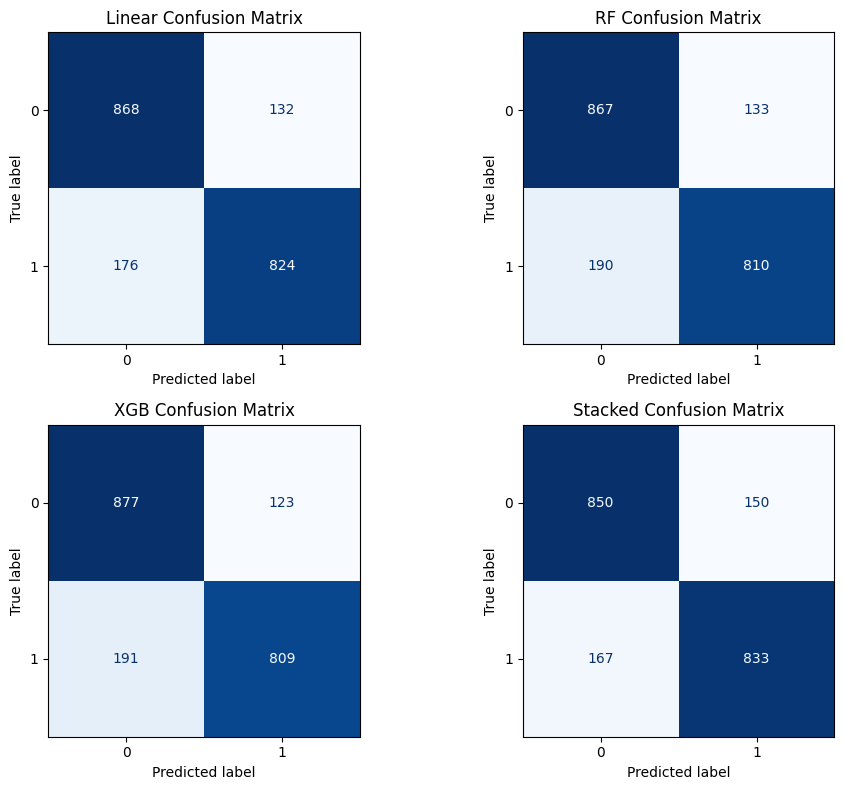


--- 8. Analisi Errori Condivisi ---
Percentuale di battaglie sbagliate da N modelli:
0   78.30%
1    4.80%
2    3.15%
3    3.00%
4   10.75%

--- 9. Training Finale e Submission ---
Addestramento del modello Stacked su tutti i dati...


c:\Users\Rachele\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Creazione delle predizioni...

File 'submission_stacked2.csv' creato con successo!
Tempo totale esecuzione: 2.84 minuti


In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier 
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
import os
import time
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
from typing import List, Dict

# --- Importazioni dal tuo file di utility ---
from start_utils import build_pokedex, create_features, read_train_data, read_test_data

def main():
    # Ignora i warning per un output più pulito
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    # === 1. CARICAMENTO DATI ===
    print("--- 1. Caricamento Dati ---")
    COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
    DATA_PATH = 'input' 
    
    train_file_path = os.path.join(DATA_PATH, COMPETITION_NAME, 'train.jsonl')
    test_file_path = os.path.join(DATA_PATH, COMPETITION_NAME, 'test.jsonl')

    try:
        train_data = read_train_data(train_file_path)
        test_data = read_test_data(test_file_path)
        print(f"Dati di training caricati: {len(train_data)} battaglie.")
        print(f"Dati di test caricati: {len(test_data)} battaglie.")
    except FileNotFoundError:
        print(f"ERRORE: Dati non trovati. Assicurati che la cartella '{DATA_PATH}/{COMPETITION_NAME}' esista.")
        return
    
    # --- 2. COSTRUZIONE POKEDEX  ---
    # Combiniamo i dati per trovare tutti i Pokémon
    all_data = train_data + test_data
    # CHIAMIAMO LA FUNZIONE per creare il dizionario
    POKEDEX = build_pokedex(all_data)

    # === 2. CREAZIONE FEATURE ===
    print("\n--- 2. Creazione Feature (Feature Engineering) ---")
    
    print("Processing training data...")
    train_df = create_features(train_data,POKEDEX)
    
    print("\nProcessing test data...")
    test_df = create_features(test_data,POKEDEX, is_test=True)

    # === 3. SELEZIONE FEATURE ===
    print("\n--- 3. Selezione Feature (Pre-Training) ---")

    # Usiamo le feature che sappiamo essere forti
    # (Sentiti libero di usare la tua lista 'TOP_FEATURES' se l'hai salvata)
    features_da_usare = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]
    
    print(f"Utilizzo di {len(features_da_usare)} feature totali.")

    TARGET = 'player_won'
    
    X = train_df[features_da_usare]
    y = train_df[TARGET]
    X_test = test_df[features_da_usare]

    # === 4. DIVISIONE DATI PER ANALISI ERRORI ===
    # Per analizzare gli errori, abbiamo bisogno di un set di validazione
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Dati divisi in Training ({X_train.shape[0]}) e Validazione ({X_val.shape[0]})")

    # === 5. DEFINIZIONE DEI MODELLI BASE (PIPES) ===
    print("\n--- 5. Definizione dei Modelli Base ---")
    start_time = time.time()

    # Pipa 1: Modello Lineare (Veloce e Stabile)
    # (Usa StandardScaler perché i modelli lineari ne hanno bisogno)
    linear_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(random_state=42, max_iter=1000))
    ])

    # Pipa 2: Random Forest (Bravo con le interazioni)
    # (Usa i parametri che avevamo trovato buoni)
    rf_pipe = RandomForestClassifier(
        n_estimators=300, 
        max_depth=7, 
        random_state=42, 
        n_jobs=-1
    )

    # Pipa 3: XGBoost (Spesso il più potente)
    # (Usa i parametri che avevamo trovato buoni in passato)
    xg_pipe = XGBClassifier(
        n_estimators=500,
        learning_rate=0.1,
        max_depth=7,
        random_state=42,
        n_jobs=-1
    )

    # === 6. CREAZIONE DELLO STACKING CLASSIFIER ===
    print("Creazione dello StackingClassifier...")

    # Stacking: addestra i 3 modelli base e poi addestra un "Meta-Modello"
    # (LogisticRegression) per imparare a quale modello base credere.
    stacking_clf = StackingClassifier(
        estimators=[
            ('linear', linear_pipe),
            ('rf', rf_pipe),
            ('xgb', xg_pipe)
        ],
        final_estimator=LogisticRegression(max_iter=1000), # Il "Meta-Modello"
        passthrough=True, # Passa anche le feature originali al meta-modello
        cv=5, # Cross-validation per addestrare i modelli base
        n_jobs=-1
    )

    # === 7. ADDESTRAMENTO E ANALISI ERRORI ===
    print("\n--- 7. Addestramento Modelli e Analisi Matrici di Confusione ---")
    
    models = {
        'Linear': linear_pipe,
        'RF': rf_pipe,
        'XGB': xg_pipe,
        'Stacked': stacking_clf # Il nostro nuovo modello combinato
    }

    # Dizionario per salvare le predizioni per l'analisi
    preds = {}

    # Creiamo una griglia di grafici 2x2
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel() # Trasforma la griglia 2x2 in un array piatto

    for i, (name, model) in enumerate(models.items()):
        print(f"Addestramento {name}...")
        model.fit(X_train, y_train)
        
        print(f"Valutazione {name}...")
        y_pred = model.predict(X_val)
        preds[name] = y_pred # Salva le predizioni
        
        val_accuracy = accuracy_score(y_val, y_pred)
        print(f"   -> Accuratezza {name} su Validazione: {val_accuracy:.4f}")

        # Disegna la Matrice di Confusione
        cm = confusion_matrix(y_val, y_pred)
        ConfusionMatrixDisplay(cm).plot(ax=axes[i], cmap='Blues', colorbar=False)
        axes[i].set_title(f"{name} Confusion Matrix")

    plt.tight_layout()
    plt.show()

    # === 8. ANALISI ERRORI CONDIVISI ===
    print("\n--- 8. Analisi Errori Condivisi ---")
    
    # Crea un DataFrame con le predizioni e la verità
    pred_df = pd.DataFrame(preds)
    pred_df['true'] = y_val.reset_index(drop=True)

    # Identifica dove ogni modello ha sbagliato
    miss_df = pd.DataFrame({
        name: (pred_df[name] != pred_df['true']).astype(int)
        for name in preds.keys()
    })

    # Conta quanti modelli hanno sbagliato la STESSA battaglia
    shared_miss = miss_df.sum(axis=1)
    prop_shared = (shared_miss.value_counts(normalize=True) * 100).sort_index()

    print("Percentuale di battaglie sbagliate da N modelli:")
    print(prop_shared.to_string(float_format="%.2f%%"))

    # === 9. SUBMISSION FINALE ===
    # Ora che abbiamo analizzato i modelli, addestriamo il migliore (lo 'Stacked')
    # su TUTTI i dati di training (X e y) per la submission finale.
    
    print("\n--- 9. Training Finale e Submission ---")
    print("Addestramento del modello Stacked su tutti i dati...")
    
    final_model = stacking_clf # Usiamo il nostro modello migliore
    final_model.fit(X, y) # Addestramento finale su X e y (tutti i dati)
    
    print("Creazione delle predizioni...")
    final_predictions = final_model.predict(X_test)
    
    submission_df = pd.DataFrame({
        'battle_id': test_df['battle_id'],
        TARGET: final_predictions
    })

    submission_df.to_csv('submission_stacked2.csv', index=False)
    
    end_time = time.time()
    print(f"\nFile 'submission_stacked2.csv' creato con successo!")
    print(f"Tempo totale esecuzione: {(end_time - start_time) / 60:.2f} minuti")

# --- Esecuzione dello script ---
if __name__ == "__main__":
    main()

--- 1. Caricamento Dati ---
Dati di training caricati: 10000 battaglie.
Dati di test caricati: 5000 battaglie.
Costruzione del Pokédex dai dati di battaglia...


Building Pokedex:   0%|          | 0/15000 [00:00<?, ?it/s]

Pokédex costruito! Trovati 20 Pokémon unici.

--- 2. Creazione Feature (Feature Engineering) ---
Processing training data...


Extracting features:   0%|          | 0/10000 [00:00<?, ?it/s]


Processing test data...


Extracting features:   0%|          | 0/5000 [00:00<?, ?it/s]


--- 3. Selezione Feature (Pre-Training) ---
Utilizzo di 46 feature totali.
Dati divisi in Training (8000) e Validazione (2000)

--- 5. Definizione dei Modelli Base ---
Creazione dello StackingClassifier...

--- 7. Addestramento Modelli e Analisi Matrici di Confusione ---
Addestramento Linear...
Valutazione Linear...
   -> Accuratezza Linear su Validazione: 0.8425
Addestramento RF...
Valutazione RF...
   -> Accuratezza RF su Validazione: 0.8260
Addestramento XGB...
Valutazione XGB...
   -> Accuratezza XGB su Validazione: 0.8345
Addestramento Stacked...


c:\Users\Rachele\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Valutazione Stacked...
   -> Accuratezza Stacked su Validazione: 0.8440


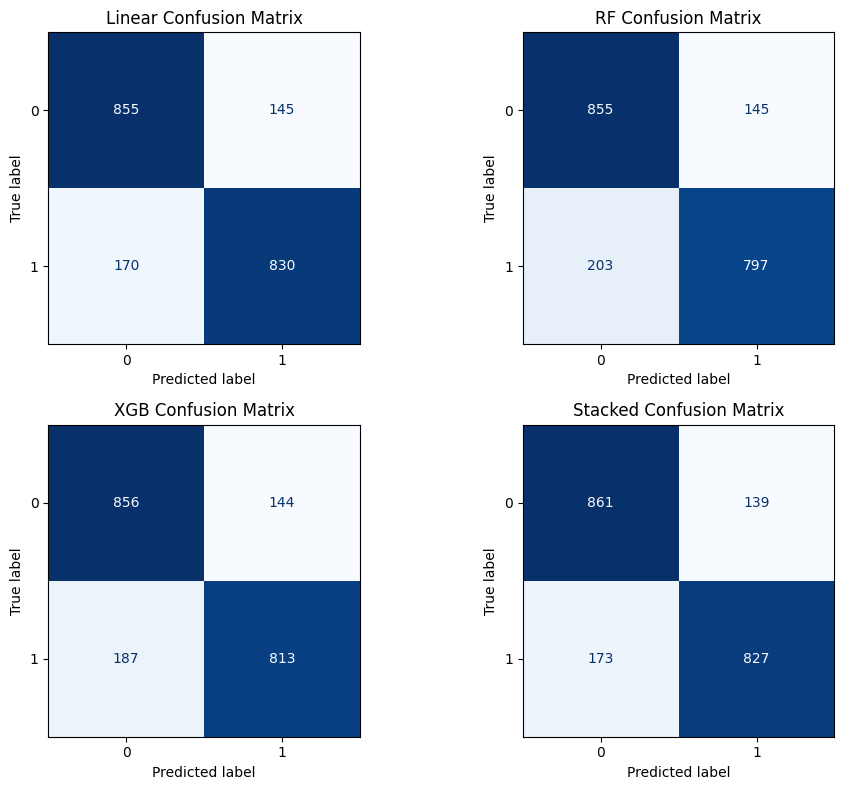


--- 8. Analisi Errori Condivisi ---
Percentuale di battaglie sbagliate da N modelli:
0   77.85%
1    4.65%
2    3.20%
3    2.95%
4   11.35%

--- 9. Training Finale e Submission ---
Addestramento del modello Stacked su tutti i dati...


c:\Users\Rachele\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Creazione delle predizioni...

File 'submission_stacked.csv' creato con successo!
Tempo totale esecuzione: 1.76 minuti


In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier 
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
import os
import time
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
from typing import List, Dict

# --- Importazioni dal tuo file di utility ---
from stacking_final import build_pokedex, create_features, read_train_data, read_test_data

def main():
    # Ignora i warning per un output più pulito
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    # === 1. CARICAMENTO DATI ===
    print("--- 1. Caricamento Dati ---")
    COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
    DATA_PATH = 'input' 
    
    train_file_path = os.path.join(DATA_PATH, COMPETITION_NAME, 'train.jsonl')
    test_file_path = os.path.join(DATA_PATH, COMPETITION_NAME, 'test.jsonl')

    try:
        train_data = read_train_data(train_file_path)
        test_data = read_test_data(test_file_path)
        print(f"Dati di training caricati: {len(train_data)} battaglie.")
        print(f"Dati di test caricati: {len(test_data)} battaglie.")
    except FileNotFoundError:
        print(f"ERRORE: Dati non trovati. Assicurati che la cartella '{DATA_PATH}/{COMPETITION_NAME}' esista.")
        return
    
    # --- 2. COSTRUZIONE POKEDEX  ---
    # Combiniamo i dati per trovare tutti i Pokémon
    all_data = train_data + test_data
    # CHIAMIAMO LA FUNZIONE per creare il dizionario
    POKEDEX = build_pokedex(all_data)

    # === 2. CREAZIONE FEATURE ===
    print("\n--- 2. Creazione Feature (Feature Engineering) ---")
    
    print("Processing training data...")
    train_df = create_features(train_data,POKEDEX)
    
    print("\nProcessing test data...")
    test_df = create_features(test_data,POKEDEX, is_test=True)

    # === 3. SELEZIONE FEATURE ===
    print("\n--- 3. Selezione Feature (Pre-Training) ---")

    # Usiamo le feature che sappiamo essere forti
    # (Sentiti libero di usare la tua lista 'TOP_FEATURES' se l'hai salvata)
    features_da_usare = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]
    
    print(f"Utilizzo di {len(features_da_usare)} feature totali.")

    TARGET = 'player_won'
    
    X = train_df[features_da_usare]
    y = train_df[TARGET]
    X_test = test_df[features_da_usare]

    # === 4. DIVISIONE DATI PER ANALISI ERRORI ===
    # Per analizzare gli errori, abbiamo bisogno di un set di validazione
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Dati divisi in Training ({X_train.shape[0]}) e Validazione ({X_val.shape[0]})")

    # === 5. DEFINIZIONE DEI MODELLI BASE (PIPES) ===
    print("\n--- 5. Definizione dei Modelli Base ---")
    start_time = time.time()

    # Pipa 1: Modello Lineare (Veloce e Stabile)
    # (Usa StandardScaler perché i modelli lineari ne hanno bisogno)
    linear_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(random_state=42, max_iter=1000))
    ])

    # Pipa 2: Random Forest (Bravo con le interazioni)
    # (Usa i parametri che avevamo trovato buoni)
    rf_pipe = RandomForestClassifier(
        n_estimators=300, 
        max_depth=7, 
        random_state=42, 
        n_jobs=-1
    )

    # Pipa 3: XGBoost (Spesso il più potente)
    # (Usa i parametri che avevamo trovato buoni in passato)
    xg_pipe = XGBClassifier(
        n_estimators=500,
        learning_rate=0.1,
        max_depth=7,
        random_state=42,
        n_jobs=-1
    )

    # === 6. CREAZIONE DELLO STACKING CLASSIFIER ===
    print("Creazione dello StackingClassifier...")

    # Stacking: addestra i 3 modelli base e poi addestra un "Meta-Modello"
    # (LogisticRegression) per imparare a quale modello base credere.
    stacking_clf = StackingClassifier(
        estimators=[
            ('linear', linear_pipe),
            ('rf', rf_pipe),
            ('xgb', xg_pipe)
        ],
        final_estimator=LogisticRegression(max_iter=1000), # Il "Meta-Modello"
        passthrough=True, # Passa anche le feature originali al meta-modello
        cv=5, # Cross-validation per addestrare i modelli base
        n_jobs=-1
    )

    # === 7. ADDESTRAMENTO E ANALISI ERRORI ===
    print("\n--- 7. Addestramento Modelli e Analisi Matrici di Confusione ---")
    
    models = {
        'Linear': linear_pipe,
        'RF': rf_pipe,
        'XGB': xg_pipe,
        'Stacked': stacking_clf # Il nostro nuovo modello combinato
    }

    # Dizionario per salvare le predizioni per l'analisi
    preds = {}

    # Creiamo una griglia di grafici 2x2
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel() # Trasforma la griglia 2x2 in un array piatto

    for i, (name, model) in enumerate(models.items()):
        print(f"Addestramento {name}...")
        model.fit(X_train, y_train)
        
        print(f"Valutazione {name}...")
        y_pred = model.predict(X_val)
        preds[name] = y_pred # Salva le predizioni
        
        val_accuracy = accuracy_score(y_val, y_pred)
        print(f"   -> Accuratezza {name} su Validazione: {val_accuracy:.4f}")

        # Disegna la Matrice di Confusione
        cm = confusion_matrix(y_val, y_pred)
        ConfusionMatrixDisplay(cm).plot(ax=axes[i], cmap='Blues', colorbar=False)
        axes[i].set_title(f"{name} Confusion Matrix")

    plt.tight_layout()
    plt.show()

    # === 8. ANALISI ERRORI CONDIVISI ===
    print("\n--- 8. Analisi Errori Condivisi ---")
    
    # Crea un DataFrame con le predizioni e la verità
    pred_df = pd.DataFrame(preds)
    pred_df['true'] = y_val.reset_index(drop=True)

    # Identifica dove ogni modello ha sbagliato
    miss_df = pd.DataFrame({
        name: (pred_df[name] != pred_df['true']).astype(int)
        for name in preds.keys()
    })

    # Conta quanti modelli hanno sbagliato la STESSA battaglia
    shared_miss = miss_df.sum(axis=1)
    prop_shared = (shared_miss.value_counts(normalize=True) * 100).sort_index()

    print("Percentuale di battaglie sbagliate da N modelli:")
    print(prop_shared.to_string(float_format="%.2f%%"))

    # === 9. SUBMISSION FINALE ===
    # Ora che abbiamo analizzato i modelli, addestriamo il migliore (lo 'Stacked')
    # su TUTTI i dati di training (X e y) per la submission finale.
    
    print("\n--- 9. Training Finale e Submission ---")
    print("Addestramento del modello Stacked su tutti i dati...")
    
    final_model = stacking_clf # Usiamo il nostro modello migliore
    final_model.fit(X, y) # Addestramento finale su X e y (tutti i dati)
    
    print("Creazione delle predizioni...")
    final_predictions = final_model.predict(X_test)
    
    submission_df = pd.DataFrame({
        'battle_id': test_df['battle_id'],
        TARGET: final_predictions
    })

    submission_df.to_csv('submission_stacked.csv', index=False)
    
    end_time = time.time()
    print(f"\nFile 'submission_stacked.csv' creato con successo!")
    print(f"Tempo totale esecuzione: {(end_time - start_time) / 60:.2f} minuti")

# --- Esecuzione dello script ---
if __name__ == "__main__":
    main()

In [2]:
import os
import time
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
from typing import List, Dict 
import warnings
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from stacking_final import (
    build_pokedex, 
    create_features, 
    read_train_data, 
    read_test_data,
    final  
)

# Ignora i warning per un output più pulito
warnings.simplefilter(action='ignore', category=FutureWarning)


# === 3. CARICAMENTO DATI E POKEDEX ===
print("--- 1. Caricamento Dati ---")
COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
DATA_PATH = 'input'

train_file_path = os.path.join(DATA_PATH, COMPETITION_NAME, 'train.jsonl')
test_file_path = os.path.join(DATA_PATH, COMPETITION_NAME, 'test.jsonl')

train_data = read_train_data(train_file_path)
test_data = read_test_data(test_file_path)

print("--- 2. Costruzione Pokédex ---")
POKEDEX = build_pokedex(train_data + test_data)


# === 4. CREAZIONE FEATURE ===
print("--- 3. Creazione Feature ---")
train_df = create_features(train_data, POKEDEX) 
test_df = create_features(test_data, POKEDEX, is_test=True) 

# === 5. PREPARAZIONE X, y, X_test ===
print("--- 4. Preparazione Dati per il Modello ---")
TARGET = 'player_won'
features = [col for col in train_df.columns if col not in ['battle_id', TARGET]]

X = train_df[features]
y = train_df[TARGET]
X_test = test_df[features]

# === 6. DEFINIZIONE MODELLO ===
print("--- 5. Definizione Modello Stacked ---")
# (Questo è il tuo codice per definire 'stacked_model', con BASE=True o BASE=False)
BASE = True # Imposta questo su False se vuoi eseguire il RandomizedSearchCV
if BASE:
    rf = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=1234, n_jobs=-1)
    gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.03, max_depth=3, random_state=1234)
    stacked_model = StackingClassifier(
        estimators=[('rf', rf), ('gb', gb)],
        final_estimator=LogisticRegression(max_iter=2000, C=0.05, random_state=1234), 
        passthrough=False, 
        n_jobs=-1
    )
    print("Modello 'BASE' (pre-configurato) definito.")
else:
    # (Qui va la tua logica per 'stacked_model_base', 'param_grid' e 'RandomizedSearchCV')
    print("Definizione di RandomizedSearchCV (può richiedere molto tempo)...")
    pass # Assicurati che 'stacked_model' sia definito qui se BASE=False


# === 7. ESECUZIONE E VALUTAZIONE FINALE ===
print("\n--- 6. Esecuzione Addestramento e Valutazione Finale ---")
# Chiama la funzione 'final' e ricevi indietro il modello addestrato e le feature usate
# Passiamo il modello 'stacked_model' (Base o Ottimizzato), X e y
final_pipe, selected_features = final(stacked_model, X, y)


# === 8. CREA SUBMISSION ===
print("\n--- 7. Creazione File di Submission ---")

# Filtra X_test per usare SOLO le feature che 'final' ha selezionato
X_test_selected = X_test[selected_features]

# Usa il 'final_pipe' (che è già addestrato) per predire
predictions = final_pipe.predict(X_test_selected)

submission_df = pd.DataFrame({
    'battle_id': test_df['battle_id'],
    TARGET: predictions
})

submission_df.to_csv('submission_final_stacked.csv', index=False)
print("File 'submission_final_stacked.csv' creato con successo!")

def final(stacked_model_to_train, X_train_data, y_train_data):
    """
    Addestra il modello usando TUTTE le feature fornite, 
    e stampa le metriche di performance.
    """
    
    # --- MODIFICA CHIAVE: Usa tutte le colonne di X_train_data ---
    selected = X_train_data.columns.tolist()
    X_selected = X_train_data 
    
    print(f"Addestramento su {len(selected)} feature totali...")
    
    # Addestra il modello
    stacked_model_to_train.fit(X_selected, y_train_data)
    final_pipe = stacked_model_to_train
    
    #--- VALUTAZIONE (Accuracy) ---
    print("Calcolo Accuracy (Cross-Validation)...")
    
    # Calcola l'accuracy usando 5-fold CV
    acc_scores = cross_val_score(final_pipe, X_selected, y_train_data, cv=5, scoring='accuracy')
    
    # Stampa i risultati in modo chiaro
    print("\n" + "="*40)
    print(f"✅ ACCURACY MEDIA (CV): {acc_scores.mean():.4f} (+/- {acc_scores.std():.4f})")
    print("="*40 + "\n")
    
    # Ritorna il modello e la lista delle feature usate
    return final_pipe, selected

--- 1. Caricamento Dati ---
--- 2. Costruzione Pokédex ---
Costruzione del Pokédex dai dati di battaglia...


Building Pokedex:   0%|          | 0/15000 [00:00<?, ?it/s]

Pokédex costruito! Trovati 20 Pokémon unici.
--- 3. Creazione Feature ---


Extracting features:   0%|          | 0/10000 [00:00<?, ?it/s]

Extracting features:   0%|          | 0/5000 [00:00<?, ?it/s]

--- 4. Preparazione Dati per il Modello ---
--- 5. Definizione Modello Stacked ---
Modello 'BASE' (pre-configurato) definito.

--- 6. Esecuzione Addestramento e Valutazione Finale ---
Esecuzione di 'final' con 16 feature selezionate...
Addestramento del modello finale sul set di feature selezionate...
Valutazione del modello (Controllo Overfitting)...

--- Risultati Finali ---
featureArray,accuracy_score_training,roc_auc_score,accuracy_cross_val_score,roc_auc_cross_val_score
['diff_type_advantage', 'p1_type_advantage', 'diff_status', 'diff_speed_first', 'diff_stat', 'p2_hp_pct_sum', 'diff_hp_pct', 'p1_number_attacks', 'p1_number_status', 'p2_sum_negative_priority', 'p1_move_power_weighted', 'boost_p1', 'boost_p2', 'diff_boost', 'sum_stat_lead_p1', 'sum_stat_lead_p2'],0.8320, 0.9085, 0.8205 ± 0.0138, 0.8927 ± 0.0091

--- 7. Creazione File di Submission ---
File 'submission_final_stacked.csv' creato con successo!
